# Identification of spam text messages

_partially based on [this tutorial](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb)_

We have a dataset of SMS in English labelled as malicious ("spam") or useful ("ham"). We will use a bi-directional RNN with LSTM cells to classify them.

**Table of contents**:
1. [Data preparation](#data_preparation)
2. [Model description](#model_description)
3. [Model training](#model_training)
4. [Exercises](#exercises)

In [61]:
import numpy as np
import time
import torch
from torch import nn
import torch.optim as optim
from nltk import wordpunct_tokenize
import matplotlib.pyplot as plt
%matplotlib inline

<a id='data_preparation'></a>
### Data preparation

In [4]:
!wget -O sms_spam.txt "https://drive.google.com/uc?export=download&id=1OcasoyGjTRh9xBhtRnmvVLjcJaXW4uTC"

--2019-11-20 15:57:47--  https://drive.google.com/uc?export=download&id=1OcasoyGjTRh9xBhtRnmvVLjcJaXW4uTC
Resolving drive.google.com (drive.google.com)... 64.233.162.194, 2a00:1450:4010:c05::c2
Connecting to drive.google.com (drive.google.com)|64.233.162.194|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lg5e3ucairnuak4e3gebvjojt9qbneo1/1574258400000/06955062529639551827/*/1OcasoyGjTRh9xBhtRnmvVLjcJaXW4uTC?e=download [following]
--2019-11-20 15:57:47--  https://doc-0g-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lg5e3ucairnuak4e3gebvjojt9qbneo1/1574258400000/06955062529639551827/*/1OcasoyGjTRh9xBhtRnmvVLjcJaXW4uTC?e=download
Resolving doc-0g-58-docs.googleusercontent.com (doc-0g-58-docs.googleusercontent.com)... 64.233.165.132, 2a00:1450:4010:c08::84
Connecting to doc-0g-58-docs.googleusercontent.com (doc-0g-58-docs.goog

Load the data and get the vocabulary:

In [62]:
# load the data
def load_data(path):
    vocab = set()
    text = []
    labels = []
    label_dict = {'ham': [1, 0], 'spam': [0, 1]}
    for line in open(path):
        [label, txt] = line.lower().strip('\n').split('\t')
        words = wordpunct_tokenize(txt)
        vocab.update(words)
        text.append(words)
        labels.append(label_dict[label])
    return text, labels, vocab
txt, labels, vocab = load_data('sms_spam.txt')

Unlike the previous experiments, here we will use pre-trained word embeddings (GloVe).

Let us get the embeddings:

In [748]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-11-20 14:27:10--  https://91.77.165.184:8890/lab/tree/glove.6B.100d.tar.xz
Connecting to 91.77.165.184:8890... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 302 Found
Location: /login?next=%2Flab%2Ftree%2Fglove.6B.100d.tar.xz [following]
--2019-11-20 14:27:10--  https://91.77.165.184:8890/login?next=%2Flab%2Ftree%2Fglove.6B.100d.tar.xz
Reusing existing connection to 91.77.165.184:8890.
HTTP request sent, awaiting response... 200 OK
Length: 6677 (6.5K) [text/html]
Saving to: ‘glove100.6B.100d.tar.xz’

glove100.6B.100d.ta 100%[===================>]   6.52K  --.-KB/s    in 0s      

2019-11-20 14:27:10 (993 MB/s) - ‘glove100.6B.100d.tar.xz’ saved [6677/6677]



Here we load the embeddings and transform the vocabulary so that it includes only words that occur in the data and for which embeddings exist:

In [63]:
# load the embeddings
def load_embeddings(emb_path, vocab):
    clf_embeddings = {}
    emb_vocab = set()
    for line in open(emb_path):
        line = line.strip('\n').split()
        word, emb = line[0], line[1:]
        emb = [float(e) for e in emb]
        if word in vocab:
            clf_embeddings[word] = emb
    for w in vocab:
        if w in clf_embeddings:
            emb_vocab.add(w)
    word2idx = {w: idx for (idx, w) in enumerate(emb_vocab)}
    max_val = max(word2idx.values())
    
    word2idx['UNK'] = max_val + 1
    word2idx['EOS'] = max_val + 2
    emb_dim = len(list(clf_embeddings.values())[0])
    clf_embeddings['UNK'] = [0.0 for i in range(emb_dim)]
    clf_embeddings['EOS'] = [0.0 for i in range(emb_dim)]
    
    embeddings = [[] for i in range(len(word2idx))]
    for w in word2idx:
        embeddings[word2idx[w]] = clf_embeddings[w]
    embeddings = torch.Tensor(embeddings)
    return embeddings, word2idx
embeddings, vocab = load_embeddings('../../glove.6B.100d.txt', vocab)

Let us check the lengths of sentences in the dataset:

Average SMS length:  19.554897739504845


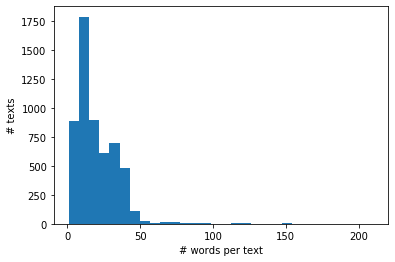

In [64]:
txt_lengths = [len(t) for t in txt] 
print('Average SMS length: ', np.average(txt_lengths))
p = plt.hist(txt_lengths, bins=30)
l = plt.xlabel('# words per text')
l = plt.ylabel('# texts')

Since the majority of sentences are not longer than 50 words, we can truncate longer texts:

In [65]:
txt = [t[:50] for t in txt]

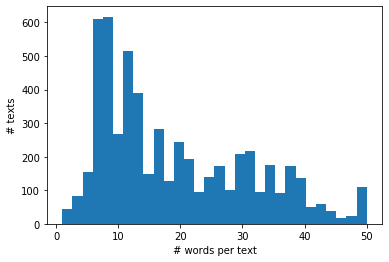

In [66]:
p = plt.hist([len(t) for t in txt] , bins=30)
l = plt.xlabel('# words per text')
l = plt.ylabel('# texts')

We need to transform a list of lines of different lengths to a matrix which can be used as an input to a neural network.

We pad the shorter lines with EOS symbol to match the length of the longest line in a batch:

In [67]:
def to_matrix(lines, vocab, max_len=None, dtype='int32'):
    """Casts a list of lines into a matrix"""
    pad = vocab['EOS']
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = [vocab.get(l, vocab['UNK']) for l in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
    lines_ix = torch.LongTensor(lines_ix)
    return lines_ix

Let us check the performance of this procedure:

In [68]:
dummy_lines = [
    ['one'],
    ['one', 'two'],
    ['the', 'long', 'line'],
    ['unkn0wn', 'w0rds']
]
print(to_matrix(dummy_lines, vocab))

tensor([[4307, 6660, 6660],
        [4307, 3458, 6660],
        [1082, 3832, 6179],
        [6659, 6659, 6660]])


Generate the train/validation/test partition:

In [69]:
train_data, valid_data, test_data = [], [], []
for idx, (t, l) in enumerate(zip(txt, labels)):
    t = to_matrix([t], vocab)
    l = torch.Tensor([l])
    if idx % 10 == 0:
        valid_data.append((t, l))
    elif (idx+1) % 10 == 0:
        test_data.append((t, l))
    else:
        train_data.append((t, l))

<a id='model_description'></a>
### Model

Let us now define our model. It will consist of:
- an embedding layer which will use pre-trained GloVe embeddings with no fine-tuning
- a layer of LSTM cells
- a dense layer that will convert the LSTM output to scores of labels

In [70]:
class BiLSTM(nn.Module):
    def __init__(self, embeddings, hidden_dim=128, lstm_layer=1, output=2):
        
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        
        # load pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(embeddings)
        # embeddings are not fine-tuned
        self.embedding.weight.requires_grad = False
        
        # RNN layer with LSTM cells
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer, 
                            bidirectional=True)
        # dense layer
        self.output = nn.Linear(hidden_dim*2, output)
    
    def forward(self, sents):
        x = self.embedding(sents)
        
        # the original dimensions of torch LSTM's output are: (seq_len, batch, num_directions * hidden_size)
        lstm_out, _ = self.lstm(x)
        
        # reshape to get the tensor of dimensions (seq_len, batch, num_directions, hidden_size)
        lstm_out = lstm_out.view(x.shape[0], -1, 2, self.hidden_dim)#.squeeze(1)
        
        # lstm_out[:, :, 0, :] -- output of the forward LSTM
        # lstm_out[:, :, 1, :] -- output of the backward LSTM
        # we take the last hidden state of the forward LSTM and the first hidden state of the backward LSTM
        dense_input = torch.cat((lstm_out[-1, :, 0, :], lstm_out[0, :, 1, :]), dim=1)
        
        y = self.output(dense_input).view([1, 2])
        return y

Let us initialise the model, optimiser, and loss:

In [71]:
hidden_dim = 128
layers = 1

model = BiLSTM(embeddings, hidden_dim, lstm_layer=layers)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

Check the number of trainable parameters in the model:

In [72]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 236,034 trainable parameters


Transfer the model and loss to GPU:

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Besides loss, we also need a metric which is interpretable by humans. We will use accuracy:

In [74]:
def binary_accuracy(preds, y):
    # y is either [0, 1] or [1, 0]
    # get the class (0 or 1)
    y = torch.argmax(y, dim=1)
    
    # get the predicted class
    preds = torch.argmax(torch.sigmoid(preds), dim=1)
    
    correct = (preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

<a id='model_training'></a>
### Training of a model

The procedure to perform one epoch of training:

In [75]:
def train(model, train_data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model to the training mode
    model.train(mode=True)
    
    for t, l in train_data:
        # reshape the data to n_words x batch_size (here batch_size=1)
        t = t.view((-1, 1))
        # transfer the data to GPU to make it accessible for the model and the loss
        t = t.to(device)
        l = l.to(device)
        
        # set all gradients to zero
        optimizer.zero_grad()
        
        # forward pass of training
        # compute predictions with current parameters
        predictions = model(t)
        # compute the loss
        loss = criterion(predictions, l)
        # compute the accuracy (this is only for report)
        acc = binary_accuracy(predictions, l)
        
        # backward pass (fully handled by pytorch)
        loss.backward()
        # update all parameters according to their gradients
        optimizer.step()
        
        # data for report
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(train_data), epoch_acc / len(train_data)

The evaluation procedure computes loss and accuracy, but does not update gradients:

In [76]:
def evaluate(model, test_data, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for t, l in test_data:
            t = t.view((-1, 1))
            t = t.to(device)
            l = l.to(device)
            predictions = model(t)
            
            loss = criterion(predictions, l)
            acc = binary_accuracy(predictions, l)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(test_data), epoch_acc / len(test_data)

Procedure to compute the time between *start_time* and *end_time* points (we'll use it to note the time during training):

In [77]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Run training and evaluation for several epochs:

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_data, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 0.432 | Train Acc: 86.79%
	 Val. Loss: 0.397 |  Val. Acc: 84.05%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.347 | Train Acc: 87.17%
	 Val. Loss: 0.386 |  Val. Acc: 84.05%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.335 | Train Acc: 87.17%
	 Val. Loss: 0.371 |  Val. Acc: 84.05%


<a id='exercises'></a>
### Exercises

1. Change the parameters of model, find the best configuration:
 - add another layer,
 - increase the number of cells in the hidden layer,
 - change LSTM cells to GRU.
2. Compute F$_1$-score on the validation set.
3. Use <code>torchtext</code> library to load the text and generate batches.
4. \*Change the model so that it can solve the regression task. You can use reviews from the [Movie\$ Data corpus](http://www.cs.cmu.edu/~ark/movie$-data/) or the [dataset](http://hdl.handle.net/11372/LRT-2619) for sentence-level quality estimation task.
